In [1]:
import torch 
import torch.nn as nn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('students_data.csv')
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [19]:
df.columns 
df.nunique()

StudentID            2392
Age                     4
Gender                  2
Ethnicity               4
ParentalEducation       5
StudyTimeWeekly      2392
Absences               30
Tutoring                2
ParentalSupport         5
Extracurricular         2
Sports                  2
Music                   2
Volunteering            2
GPA                  2371
GradeClass              5
dtype: int64

In [4]:
cat_cols = ['Tutoring', 'Extracurricular', 'ParentalSupport', 'Sports', 'Music', 'Volunteering', 'ParentalEducation']
cont_cols = ['StudyTimeWeekly', 'Absences', 'GPA', 'Age']
y_col = ['GradeClass']

for cat in cat_cols:
    df[cat] = df[cat].astype('category')
    
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64)


In [5]:
conts = np.stack([df[cont].values for cont in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)


In [6]:
Y = torch.tensor(df[y_col].values).flatten()

In [7]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
print(f'category sizes: {cat_szs}              embedding sizes: {emb_szs}')

category sizes: [2, 2, 5, 2, 2, 2, 5]              embedding sizes: [(2, 1), (2, 1), (5, 3), (2, 1), (2, 1), (2, 1), (5, 3)]


In [8]:
class Alex(nn.Module):
    
    def __init__(self, emb_szs, n_cont, out_features, layers, p=0.4):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        n_emb = sum([nf for ni, nf in emb_szs])
        layerlist = []
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_features))
            
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [9]:
model = Alex(emb_szs, conts.shape[1], 5, [200, 100], p=0.4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
print(len(df))

2392


In [11]:
batch_size = 2393
test_size = 1000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = Y[:batch_size-test_size]
y_test = Y[batch_size-test_size:batch_size]

In [12]:
import time 
start_time = time.time()

epochs = 800 
losses = []

y_train = y_train.long()
for i in range(epochs):
    i+=1 
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed    

epoch: 800  loss: 0.05397755

Duration: 81 seconds


In [13]:
len(losses)

800

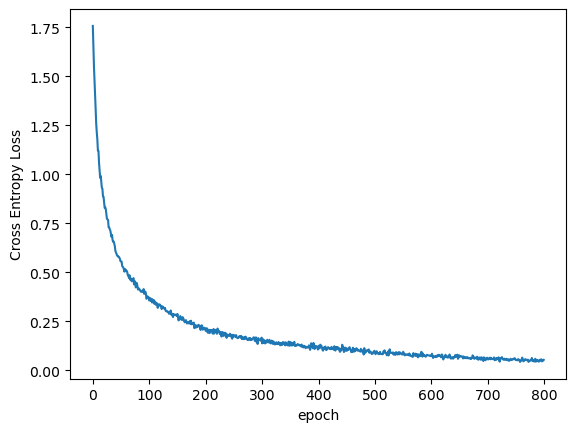

In [14]:
# Certificando-se de que todos os elementos em `losses` são números flutuantes simples
# Certificando-se de que todos os elementos em `losses` são números flutuantes simples
losses = [loss.detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in losses]

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')
plt.show()


In [15]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    # Certifique-se de que y_test é um LongTensor
    y_test = y_test.long()
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')


CE Loss: 2.71690845


In [16]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ -3.2593,   4.9463,  10.4320,   1.3459, -12.9141])    2      2   
tensor([-0.0612, -3.6199, -4.2269, -6.3817, 12.4644])    4      4   
tensor([-4.4260, -7.0274, -4.9859,  5.1828,  9.6892])    4      4   
tensor([ -1.6066,   4.1751,  10.5408,   3.5446, -13.7139])    2      2   
tensor([-1.1169, -7.3873, -8.3456,  2.1843, 12.3589])    4      4   
tensor([ -2.7296,  -8.1249, -10.6933,   5.6009,  11.6703])    4      4   
tensor([-4.4816, -6.7214, -2.5514,  7.7867,  6.1513])    3      3   
tensor([-3.7806,  1.8993,  6.5022,  5.2202, -9.3511])    2      2   
tensor([  0.3959,  -4.4515,  -4.0185, -11.1005,  17.0846])    4      4   
tensor([-4.7133, -5.9588, -3.2874,  8.8662,  5.5806])    3      4   
tensor([-6.7343, -5.5481,  1.2424, 12.3596, -0.4009])    3      3   
tensor([ -0.5782,  -7.1248, -10.4501,   2.1345,  14.7092])    4      4   
tensor([-5.5329, -1.1959,  9.1914,  7.3423, -8.4102])    2      2   
tensor([-6.5986, -5.1217,  4.8477,  

In [18]:
torch.save(model.state_dict(), 'studentGradeClassifier.pt')


Alex(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(2, 1)
    (2): Embedding(5, 3)
    (3): Embedding(2, 1)
    (4): Embedding(2, 1)
    (5): Embedding(2, 1)
    (6): Embedding(5, 3)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=5, bias=True)
  )
)